<p style="background-color:gray; font-family:newtimeroman; font-size:180%; text-align:center">Auto-Correct System</p>

In [1]:
# Downloading nltk (natural language toolkit) library for handling text type data
! pip install nltk

You should consider upgrading via the 'c:\users\jayant\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
# Importing necessary libraries
import os
import re 
import numpy as np 
import pandas as pd 
from collections import Counter # used to create frequency dictionary
import nltk

# What is Auto-correct system ?

The task of an auto-correct system is finding out which words in a document are misspelled. These mispelled words might be presented to a user by underlining that words. Correction is the task of substituting the well-spelled word for misspellings.



    Misspelled Words                            Corrected Words

    Machin                                                Machine
              ----->     AutoCorrect System  ----->   
    Lerning                                              Learning

`The very first requirement of auto-correct system is data. I have checked multiple data sources and will be using one of them.`

## Data Requirement

We need a trusted text corpus that we'll use to build the auto-correct system. There are many public domain text corpus. Since it's a unsupervised type of problem here what we need is just text. You can use any competition data or any other public dataset that has text field column. I'll be combining multiple datasets to making large corpus and then build the system on top of that.

Let's look at the corpus.

In [3]:
# Lets see the text type of data
with open('Final_data.txt', 'r',encoding='ISO-8859-1') as f:
    file = f.readlines()

In [237]:
# A small sample of the data
file[:30]

['aardvark\n',
 'aardwolf\n',
 'aaron\n',
 'aback\n',
 'abacus\n',
 'abaft\n',
 'abalone\n',
 'abandon\n',
 'abandoned\n',
 'abandonment\n',
 'abandons\n',
 'abase\n',
 'abased\n',
 'abasement\n',
 'abash\n',
 'abashed\n',
 'abate\n',
 'abated\n',
 'abatement\n',
 'abates\n',
 'abattoir\n',
 'abattoirs\n',
 'abbe\n',
 'abbess\n',
 'abbey\n',
 'abbeys\n',
 'abbot\n',
 'abbots\n',
 'abbreviate\n',
 'abbreviated\n']

Now we need to process this corpus. Since it's pretty clean corpus we need to do only two things - Tokenizing and Lowercasing.

### 1. Tokenizing - 
Tokenization is breaking the raw text into small chunks. Tokenization breaks the raw text into words, sentences called tokens.

### 2. Lowercasing -
Lowercasing means converting every text to lowercase.

In [4]:
# Tokenizing and Lowercasing
def process_data(lines):
    """
    Input: 
        A file_name which is found in your current directory. You just have to read it in. 
    Output: 
        words: a list containing all the words in the corpus (text file you read) in lower case. 
    """
    words = []        
    for line in lines:
        line = line.strip()
        line=line.lower()
        word = re.findall(r'\w+', line) # Extracting only words
        words.extend(word)
    
    return words

In [5]:
# Applying above function on text data file and making vocab
word_l = process_data(file)
vocab = set(word_l)
print(f"The first ten words in the text are: \n{word_l[0:10]}")
print('\n')
print(f"There are {len(vocab)} unique words in the vocabulary.")

The first ten words in the text are: 
['aardvark', 'aardwolf', 'aaron', 'aback', 'abacus', 'abaft', 'abalone', 'abandon', 'abandoned', 'abandonment']


There are 58110 unique words in the vocabulary.


# Architecture
<div>
<img style="align:center", src="https://miro.medium.com/max/875/1*ZpPa5v65cb2zSEzBW8wYMA.png">
    <hr>
</div>

### This auto-correct architecture has 4 components -
- **1) Filtering Mispells** : One simple approach could be checking if a word is there in the vocabulary or not. 
- **2) Word Suggestion Mechanism** : This mechnism suggests candidate words based on deletion, insertion, switch or replace of one/two characters in the original word.
- **3) Probability Distribution Mechanism** : The probability distribution {key(word) : value(probability)} is created calculated using a large text corpus. Probability of each candidate is found using this distribution and the most probable candidate is the final one.
- **4) Replace Mispells** : Simple replace the mispelled word with the most probable suggestion.

We'll impliment each part separetely.

### Artchitecture Part 1 : (Filtering Mispells)

Creating a function that tokenizes the sentences and checks the availability of each word of sentence in Vacabulary and return a list of wrong words.

In [6]:
# Function for finding a word which is not in vocabulary
def find_wrong_word(sent, vocab):
    wrong_words = []
    sent = sent.strip().lower().split(" ")
    for word in sent:
        if word not in vocab:
            wrong_words.append(word)
    return wrong_words

In [7]:
# Example for checking above function printing list of wrong words
find_wrong_word('he is goinng home', vocab)

['goinng']

***From above we can see that its finding the wrong word in sentence 
'goinng' is the wrong word***



### Architecture Part 2 : (Word Suggestion Mechanism)

We'll impliment separate functions of each of the steps (deletion, insertion, switching, replace) and then combine them to edit one or two letter(these both are function below) of the original word.

#### 1.deletion

In [8]:
# Making different different words my deleting letters from the word
def delete_letter(word, verbose=False):
    '''
    Input:
        word: the string/word for which you will generate all possible words 
                in the vocabulary which have 1 missing character
    Output:
        delete_l: a list of all possible strings obtained by deleting 1 character from word
    '''
    
    delete_l = []
    split_l = []
    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    delete_l = [s[0]+s[1][1:] for s in split_l]
    if verbose: print(f"input word : {word} \nsplit_l = {split_l}, \ndelete_l = {delete_l}")

    return delete_l

In [9]:
# Example for checking above function
delete_word_l = delete_letter(word="cans",
                        verbose=True)

input word : cans 
split_l = [('', 'cans'), ('c', 'ans'), ('ca', 'ns'), ('can', 's')], 
delete_l = ['ans', 'cns', 'cas', 'can']


#### 2.Switching

In [10]:
# Making different different words by switching letters of the word
def switch_letter(word, verbose=False):
    '''
    Input:
        word: input string
     Output:
        switches: a list of all possible strings with one adjacent charater switched
    ''' 
    
    switch_l = []
    split_l = []
    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    for s in split_l:
        if len(s[1])>2:
            temp = s[0] + s[1][1] + s[1][0] + s[1][2:]
        elif len(s[1]) == 2:
            temp = s[0] + s[1][1] + s[1][0]
        elif len(s[1]) == 1:
            continue
        switch_l.append(temp)
    
    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nswitch_l = {switch_l}") 

    return switch_l

In [11]:
# Example for checking above function
switch_word_l = switch_letter(word="eta",
                         verbose=True)

Input word = eta 
split_l = [('', 'eta'), ('e', 'ta'), ('et', 'a')] 
switch_l = ['tea', 'eat']


In [12]:
print(f"Number of outputs of switch_letter('at') is {len(switch_letter('fate'))}")

Number of outputs of switch_letter('at') is 3


#### 3.replace

In [13]:
# Making different different words by replacing letters in the word
def replace_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        replaces: a list of all possible strings where we replaced one letter from the original word. 
    ''' 
    
    letters = 'abcdefghijklmnopqrstuvwxyz'
    replace_l = []
    split_l = []
    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    for s in split_l:
        if len(s[1]) == 1:
            for l in letters:
                if l != s[1][0]:
                    temp = l
                    replace_l.append(s[0]+temp)
        elif len(s) > 1:
            for l in letters:
                if l != s[1][0]:
                    temp = l + s[1][1:]
                    replace_l.append(s[0]+temp)
        
    replace_set = set(replace_l)
    
    # turn the set back into a list and sort it, for easier viewing
    replace_l = sorted(list(replace_set))
    
    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nreplace_l {replace_l}")   
    
    return replace_l

In [14]:
# Example for checking on function
replace_l = replace_letter(word='can',
                              verbose=True)

Input word = can 
split_l = [('', 'can'), ('c', 'an'), ('ca', 'n')] 
replace_l ['aan', 'ban', 'caa', 'cab', 'cac', 'cad', 'cae', 'caf', 'cag', 'cah', 'cai', 'caj', 'cak', 'cal', 'cam', 'cao', 'cap', 'caq', 'car', 'cas', 'cat', 'cau', 'cav', 'caw', 'cax', 'cay', 'caz', 'cbn', 'ccn', 'cdn', 'cen', 'cfn', 'cgn', 'chn', 'cin', 'cjn', 'ckn', 'cln', 'cmn', 'cnn', 'con', 'cpn', 'cqn', 'crn', 'csn', 'ctn', 'cun', 'cvn', 'cwn', 'cxn', 'cyn', 'czn', 'dan', 'ean', 'fan', 'gan', 'han', 'ian', 'jan', 'kan', 'lan', 'man', 'nan', 'oan', 'pan', 'qan', 'ran', 'san', 'tan', 'uan', 'van', 'wan', 'xan', 'yan', 'zan']


#### 4.insert

In [15]:
# # Making different different words by inserting letters in the word
def insert_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        inserts: a set of all possible strings with one new letter inserted at every offset
    ''' 
    letters = 'abcdefghijklmnopqrstuvwxyz'
    insert_l = []
    split_l = []
    split_l = [(word[:i], word[i:]) for i in range(len(word)+1)]
    for s in split_l:
        for l in letters:
            insert_l.append(s[0]+l+s[1])

    if verbose: print(f"Input word {word} \nsplit_l = {split_l} \ninsert_l = {insert_l}")
    
    return insert_l

In [16]:
# Example for checking on function
insert_l = insert_letter('at', True)
print(f"Number of strings output by insert_letter('at') is {len(insert_l)}")

Input word at 
split_l = [('', 'at'), ('a', 't'), ('at', '')] 
insert_l = ['aat', 'bat', 'cat', 'dat', 'eat', 'fat', 'gat', 'hat', 'iat', 'jat', 'kat', 'lat', 'mat', 'nat', 'oat', 'pat', 'qat', 'rat', 'sat', 'tat', 'uat', 'vat', 'wat', 'xat', 'yat', 'zat', 'aat', 'abt', 'act', 'adt', 'aet', 'aft', 'agt', 'aht', 'ait', 'ajt', 'akt', 'alt', 'amt', 'ant', 'aot', 'apt', 'aqt', 'art', 'ast', 'att', 'aut', 'avt', 'awt', 'axt', 'ayt', 'azt', 'ata', 'atb', 'atc', 'atd', 'ate', 'atf', 'atg', 'ath', 'ati', 'atj', 'atk', 'atl', 'atm', 'atn', 'ato', 'atp', 'atq', 'atr', 'ats', 'att', 'atu', 'atv', 'atw', 'atx', 'aty', 'atz']
Number of strings output by insert_letter('at') is 78


#### Let's combine these individual steps and impliment two function for editing one or two characters from a word.

In [17]:
# Combining all steps 
def edit_one_letter(word, allow_switches = True):
    """
    Input:
        word: the string/word for which we will generate all possible wordsthat are one edit away.
    Output:
        edit_one_set: a set of words with one possible edit. Please return a set. and not a list.
    """
    
    edit_one_set = set()
    insert_l = insert_letter(word)
    delete_l = delete_letter(word)
    replace_l = replace_letter(word)
    switch_l = switch_letter(word)
    
    if allow_switches:
        ans = insert_l + delete_l + replace_l + switch_l
    else:
        ans = insert_l + delete_l + replace_l
        
    edit_one_set = set(ans)

    return edit_one_set

In [18]:
tmp_word = "at"
tmp_edit_one_set = edit_one_letter(tmp_word)
# turn this into a list to sort it, in order to view it
tmp_edit_one_l = sorted(list(tmp_edit_one_set))

print(f"input word : {tmp_word} \nedit_one_l \n{tmp_edit_one_l}\n")
#print(f"The type of the returned object should be a set {type(tmp_edit_one_set)}")
print(f"Number of outputs from edit_one_letter('at') is {len(edit_one_letter('at'))}")

input word : at 
edit_one_l 
['a', 'aa', 'aat', 'ab', 'abt', 'ac', 'act', 'ad', 'adt', 'ae', 'aet', 'af', 'aft', 'ag', 'agt', 'ah', 'aht', 'ai', 'ait', 'aj', 'ajt', 'ak', 'akt', 'al', 'alt', 'am', 'amt', 'an', 'ant', 'ao', 'aot', 'ap', 'apt', 'aq', 'aqt', 'ar', 'art', 'as', 'ast', 'ata', 'atb', 'atc', 'atd', 'ate', 'atf', 'atg', 'ath', 'ati', 'atj', 'atk', 'atl', 'atm', 'atn', 'ato', 'atp', 'atq', 'atr', 'ats', 'att', 'atu', 'atv', 'atw', 'atx', 'aty', 'atz', 'au', 'aut', 'av', 'avt', 'aw', 'awt', 'ax', 'axt', 'ay', 'ayt', 'az', 'azt', 'bat', 'bt', 'cat', 'ct', 'dat', 'dt', 'eat', 'et', 'fat', 'ft', 'gat', 'gt', 'hat', 'ht', 'iat', 'it', 'jat', 'jt', 'kat', 'kt', 'lat', 'lt', 'mat', 'mt', 'nat', 'nt', 'oat', 'ot', 'pat', 'pt', 'qat', 'qt', 'rat', 'rt', 'sat', 'st', 't', 'ta', 'tat', 'tt', 'uat', 'ut', 'vat', 'vt', 'wat', 'wt', 'xat', 'xt', 'yat', 'yt', 'zat', 'zt']

Number of outputs from edit_one_letter('at') is 129


In [19]:
# Making two letter edit function
def edit_two_letters(word, allow_switches = True):
    '''
    Input:
        word: the input string/word 
    Output:
        edit_two_set: a set of strings with all possible two edits
    '''
    
    edit_two_set = set()
    one_edit = edit_one_letter(word)
    ans = []
    for w in one_edit:
        ans.append(w)
        ans.extend(edit_one_letter(w))
        
    edit_two_set = set(ans)
    
    return edit_two_set

In [20]:
tmp_edit_two_set = edit_two_letters("a")
tmp_edit_two_l = sorted(list(tmp_edit_two_set))
print(f"Number of strings with edit distance of two: {len(tmp_edit_two_l)}")
print(f"First 10 strings {tmp_edit_two_l[:10]}")
print(f"Last 10 strings {tmp_edit_two_l[-10:]}")
print(f"The data type of the returned object should be a set {type(tmp_edit_two_set)}")
print(f"Number of strings that are 2 edit distances from 'at' is {len(edit_two_letters('at'))}")

Number of strings with edit distance of two: 2654
First 10 strings ['', 'a', 'aa', 'aaa', 'aab', 'aac', 'aad', 'aae', 'aaf', 'aag']
Last 10 strings ['zv', 'zva', 'zw', 'zwa', 'zx', 'zxa', 'zy', 'zya', 'zz', 'zza']
The data type of the returned object should be a set <class 'set'>
Number of strings that are 2 edit distances from 'at' is 7154


### Architecture Part 3 : (Probability Distribution)

We'll calculate the frequecies of each word using the corpus that we have. Then we'll divide each frequencies by word count to find the probabilities.

                            count(word)
    probability(word) =  ____________________
                       
                         total no. of words


In [21]:
# Finding frequencies of all the words making a dictionary
def get_count(word_l):
    '''
    Input:
        word_l: a set of words representing the corpus. 
    Output:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    '''
    word_count_dict = {}  
    word_count_dict = Counter(word_l)
    return word_count_dict

In [22]:
# Example for  checking on the above function
word_count_dict = get_count(word_l)
print(f"There are {len(word_count_dict)} key values pairs")
print(f"The count for the word 'thee' is {word_count_dict.get('thee',0)}")

There are 58110 key values pairs
The count for the word 'thee' is 1


In [23]:
# Getting the probability of each word in corpus
def get_probs(word_count_dict):
    '''
    Input:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    Output:
        probs: A dictionary where keys are the words and the values are the probability that a word will occur. 
    '''
    probs = {} 
    total = 1
    for word in word_count_dict.keys():
        total = total + word_count_dict[word]
        
    for word in word_count_dict.keys():
        probs[word] = word_count_dict[word]/total
    return probs

In [24]:
# Example for checking on above function
probs = get_probs(word_count_dict)
print(f"Length of probs is {len(probs)}")
print(f"P('you') is {probs['you']:.4f}")

Length of probs is 58110
P('you') is 0.0000


In [25]:
# Lets Look at the probability distribution of a sample
prob_df = pd.DataFrame({'word':probs.keys(), 'probability':probs.values()}).sort_values(by='probability', ascending=False)
prob_df.sample(5)

,word,probability
12661,declassified,0.000017
37049,pharmacy,0.000017
7167,carburettor,0.000017
48085,spirals,0.000017
7939,charting,0.000017


<AxesSubplot:xlabel='word'>

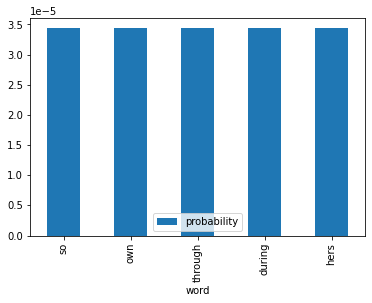

In [26]:
# Bar plot  showing probability of some words from vocab
prob_df.head().plot.bar(x='word', y='probability')

### Architecture Part 4 : (Replace Misspells with correction)

In [27]:
def get_corrections(word, probs, vocab, n=2, verbose = False):
    '''
    Input: 
        word: a user entered string to check for suggestions
        probs: a dictionary that maps each word to its probability in the corpus
        vocab: a set containing all the vocabulary
        n: number of possible word corrections you want returned in the dictionary
    Output: 
        n_best: a list of tuples with the most probable n corrected words and their probabilities.
    '''
    
    suggestions = []
    n_best = []
    
   
    if word in probs.keys():
        suggestions.append(word)
    for w in edit_one_letter(word):
        if len(suggestions) == n:
            break
        if w in probs.keys():
            suggestions.append(w)
    for w in edit_two_letters(word):
        if len(suggestions) == n:
            break
        if w in probs.keys():
            suggestions.append(w)
        
    best_words = {}
    
    for s in suggestions:
        best_words[s] = probs[s]
        
    best_words = sorted(best_words.items(), key=lambda x: x[1], reverse=True)
    
    n_best = best_words 
    
    if verbose: print("entered word = ", word, "\nsuggestions = ", suggestions)

    return n_best

In [28]:
def get_correct_word(word, vocab, probs, n): 
    corrections = get_corrections(word, probs, vocab, n, verbose=False)
#    print(corrections)
    if len(corrections) == 0:
        return word
    
    final_word = corrections[0][0]
    final_prob = corrections[0][1]
    for i, word_prob in enumerate(corrections):
        #print(f"word {i}: {word_prob[0]}, probability {word_prob[1]:.6f}")
        if word_prob[1] > final_prob:
            final_word = word_prob[0]
            final_prob = word_prob[1]
    return final_word

In [29]:
# Checking on above function
get_correct_word('annd', vocab, probs, 100,)

'and'

#### All Done!! Let's wrap up everything!

In [30]:
# Creating a single function for all above steps
def autocorrect(sentence, vocab, probs):
    print("Input sentence : ", sentence)
    wrong_words = find_wrong_word(sentence, vocab)
    print("Wrong words : ", wrong_words)
    #print(wrong_words)
    correct_words = []
    for word in sentence.strip().lower().split(" "):
        if word in wrong_words:
            correct_word = get_correct_word(word, vocab, probs, 15)
            #print(word, correct_word)
            word = correct_word
        correct_words.append(word)
    print("Output Sentence : ", " ".join(correct_words).capitalize())

## Demo

Let's check this system on some examples

In [31]:
autocorrect("he is goiing home", vocab, probs)

Input sentence :  he is goiing home
Wrong words :  ['goiing']
Output Sentence :  He is going home


In [32]:
autocorrect("honsty is the best pooliccy", vocab, probs)

Input sentence :  honsty is the best pooliccy
Wrong words :  ['honsty', 'pooliccy']
Output Sentence :  Honesty is the best policy


In [33]:
autocorrect("life is a diink annd lve is a druug", vocab, probs)

Input sentence :  life is a diink annd lve is a druug
Wrong words :  ['diink', 'annd', 'lve', 'druug']
Output Sentence :  Life is a doing and lee is a drug


In [34]:
autocorrect("ffrront", vocab, probs)

Input sentence :  ffrront
Wrong words :  ['ffrront']
Output Sentence :  Affront


### We can see that it is working!

This gives a overview of what auto-correct systems are and how they work.

Note - This is very simplified architecture compared to what is used in reality. You can see in the last example's output isn't good. It is supposed to be ("Life is a drink and love is a drug")

#### Drawbacks 
- It has fixed outcome. i.e. 'hime' will be converted to 'time' only not 'home' or anything else.
- It is solely based on frequency of words in the corpus
- Doesn't care about the contex.
- Can't suggest something which is not in the vocabulary

#### Improvements
- It can be further improved by introducing bi-gram probabilities. Hence, it will get some inference from previous words.
- The suggestions that are less distance away from the misspelled word are more likely. Hence, the system can be further improved by introducing dynamic programming based min edit distance functionality.

<hr>

## Improvement  : Introducing min_edit_diatsnce functionality

The idea is derived from the intution that the suggestions that are less distance away from the misspelled word are more likely. Hence, the system can be further improved by introducing dynamic programming based min edit distance functionality.

So, given a string source[0..i] and a string target[0..j], we will compute all the combinations of substrings[i, j] and calculate their edit distance. To do this efficiently, we will use a table to maintain the previously computed substrings and use those to calculate larger substrings.

We'll first create a matrix and update each element in the matrix as follows:

$$\text{Initialization}$$

\begin{align}
D[0,0] &= 0 \\
D[i,0] &= D[i-1,0] + del\_cost(source[i]) \\
D[0,j] &= D[0,j-1] + ins\_cost(target[j]) \\
\end{align}

$$\text{Per Cell Operations}$$
\begin{align}
 \\
D[i,j] =min
\begin{cases}
D[i-1,j] + del\_cost\\
D[i,j-1] + ins\_cost\\
D[i-1,j-1] + \left\{\begin{matrix}
rep\_cost; & if src[i]\neq tar[j]\\
0 ; & if src[i]=tar[j]
\end{matrix}\right.
\end{cases}
\end{align}


In [35]:
def min_edit_distance(source, target, ins_cost = 1, del_cost = 1, rep_cost = 2):
    '''
    Input: 
        source: a string corresponding to the string you are starting with
        target: a string corresponding to the string you want to end with
        ins_cost: an integer setting the insert cost
        del_cost: an integer setting the delete cost
        rep_cost: an integer setting the replace cost
    Output:
        D: a matrix of len(source)+1 by len(target)+1 containing minimum edit distances
        med: the minimum edit distance (med) required to convert the source string to the target
    '''
    
    m = len(source) 
    n = len(target) 
    #initialize cost matrix with zeros and dimensions (m+1,n+1) 
    D = np.zeros((m+1, n+1), dtype=int) 
    
    for row in range(1,m+1): 
        D[row,0] = D[row-1, 0] + del_cost
        
    for col in range(1,n+1):
        D[0,col] = D[0, col-1] + ins_cost
        
    # Loop through row 1 to row m
    for row in range(1,m+1): 
        # Loop through column 1 to column n
        for col in range(1,n+1):
            # Intialize r_cost to the 'replace' cost 
            r_cost = rep_cost
            # Check to see if source character at the previous row
            # matches the target character at the previous column, 
            if source[row-1] == target[col-1]:
                # Update the replacement cost to 0 if source and target are the same
                r_cost = 0
            # Update the cost at row, col based on previous entries in the cost matrix
            D[row,col] = D[row-1][col-1] + r_cost
          
    # Set the minimum edit distance with the cost found at row m, column n
    med = D[m][n]
    
    return D, med

In [36]:
# Fuction is gonaa using min-edit-distance and return number of closestwords
def calcDictDistance(word, numWords):  #'numWords' is used for number of nearest words
    file = open('/content/Final_data.txt', 'r') 
    lines = file.readlines() 
    file.close()
    dictWordDist = []
    wordIdx = 0
    
    for line in lines: 
        wordDistance = min_edit_distance(word, line.strip())[1]
        if wordDistance >= 10:
            wordDistance = 9
        dictWordDist.append(str(int(wordDistance)) + "-" + line.strip())
        wordIdx = wordIdx + 1

    closestWords = []
    wordDetails = []
    currWordDist = 0
    dictWordDist.sort()
    #print(dictWordDist)
    for i in range(numWords):
        currWordDist = dictWordDist[i]
        wordDetails = currWordDist.split("-")
        closestWords.append(wordDetails[1])
    return closestWords

In [41]:
def calcDictDistance(word, numWords):
    file = open('Final_data.txt', 'r') 
    lines = file.readlines() 
    file.close()
    dictWordDist = []
    wordIdx = 0
    
    for line in lines: 
        wordDistance = min_edit_distance(word, line.strip())[1]
        if wordDistance >= 10:
            wordDistance = 9
        dictWordDist.append(str(int(wordDistance)) + "-" + line.strip())
        wordIdx = wordIdx + 1

    closestWords = []
    wordDetails = []
    currWordDist = 0
    dictWordDist.sort()
    #print(dictWordDist)
    for i in range(numWords):
        currWordDist = dictWordDist[i]
        wordDetails = currWordDist.split("-")
        closestWords.append(wordDetails[1])
    return closestWords

In [42]:
calcDictDistance('lidrary',1)[0]

'library'

In [43]:
# Function for finding a word is not in vocab
def find_wrong_word(sent, vocab):   # Above we have created a vocab set
    wrong_words = []
    sents = sent.strip().lower().split(" ")
    for word in sents:
        if word not in vocab:
            wrong_words.append(word)
    return wrong_words

In [44]:
# Function combined everything like min-edit distance , finding wrong words
def autocorrect_min_edit(sentence,vocab):

  wrong_words=find_wrong_word(sentence,vocab)
  corrected_words=[]
  for word in wrong_words:
    corrected_words.append(calcDictDistance(word,1)[0])

  for i in range(len(corrected_words)):
    sentence=sentence.replace(wrong_words[i],corrected_words[i])
  return sentence


### Demo

In [45]:
autocorrect_min_edit('I have access to the lidrary', vocab)

'I have access to the library'

In [46]:
autocorrect_min_edit('he planed a game', vocab)

'he planed a game'

In [47]:
autocorrect_min_edit('life is a diink annd lve is a druug', vocab)

'life is a drink anna ave is a rung'

## Evaluation

Let's design a unit test for the auto-correct system that we have develpoed.

In [48]:
tests1 = {'access': 'acess',
          'accessing': 'accesing',
          'accommodation': 'accomodation acommodation acomodation',
          'account': 'acount',
          'address': 'adress adres',
          'addressable': 'addresable',
          'arranged': 'aranged arrainged',
          'arrangeing': 'aranging',
          'arrangement': 'arragment',
          'articles': 'articals',
          'aunt': 'annt anut arnt',
          'auxiliary': 'auxillary',
          'available': 'avaible',
          'awful': 'awfall afful',
          'basically': 'basicaly',
          'beginning': 'begining',
          'benefit': 'benifit',
          'benefits': 'benifits',
          'between': 'beetween',
          'bicycle': 'bicycal bycicle bycycle',
          'biscuits': 'biscits biscutes biscuts bisquits buiscits buiscuts',
          'built': 'biult',
          'cake': 'cak',
          'career': 'carrer',
          'cemetery': 'cemetary semetary',
          'centrally': 'centraly',
          'certain': 'cirtain',
          'challenges': 'chalenges chalenges',
          'chapter': 'chaper chaphter chaptur',
          'choice': 'choise',
          'choosing': 'chosing',
          'clerical': 'clearical',
          'committee': 'comittee',
          'compare': 'compair',
          'completely': 'completly',
          'consider': 'concider',
          'considerable': 'conciderable',
          'contented': 'contenpted contende contended contentid',
          'curtains': 'cartains certans courtens cuaritains curtans curtians curtions',
          'decide': 'descide',
          'decided': 'descided',
          'definitely': 'definately difinately',
          'definition': 'defenition',
          'definitions': 'defenitions',
          'description': 'discription',
          'desiccate': 'desicate dessicate dessiccate',
          'diagrammatically': 'diagrammaticaally',
          'different': 'diffrent',
          'driven': 'dirven',
          'ecstasy': 'exstacy ecstacy',
          'embarrass': 'embaras embarass',
          'establishing': 'astablishing establising',
          'experience': 'experance experiance',
          'experiences': 'experances',
          'extended': 'extented',
          'extremely': 'extreamly',
          'fails': 'failes',
          'families': 'familes',
          'february': 'febuary',
          'further': 'futher',
          'gallery': 'galery gallary gallerry gallrey',
          'hierarchal': 'hierachial',
          'hierarchy': 'hierchy',
          'inconvenient': 'inconvienient inconvient inconvinient',
          'independent': 'independant independant',
          'initial': 'intial',
          'initials': 'inetials inistals initails initals intials',
          'juice': 'guic juce jucie juise juse',
          'latest': 'lates latets latiest latist',
          'laugh': 'lagh lauf laught lugh',
          'level': 'leval',
          'levels': 'levals',
          'liaison': 'liaision liason',
          'lieu': 'liew',
          'literature': 'litriture',
          'loans': 'lones',
          'locally': 'localy',
          'magnificent': 'magnificnet magificent magnifcent magnifecent magnifiscant magnifisent magnificant',
          'management': 'managment',
          'meant': 'ment',
          'minuscule': 'miniscule',
          'minutes': 'muinets',
          'monitoring': 'monitering',
          'necessary': 'neccesary necesary neccesary necassary necassery neccasary',
          'occurrence': 'occurence occurence',
          'often': 'ofen offen offten ofton',
          'opposite': 'opisite oppasite oppesite oppisit oppisite opposit oppossite oppossitte',
          'parallel': 'paralel paralell parrallel parralell parrallell',
          'particular': 'particulaur',
          'perhaps': 'perhapse',
          'personnel': 'personnell',
          'planned': 'planed',
          'poem': 'poame',
          'poems': 'poims pomes',
          'poetry': 'poartry poertry poetre poety powetry',
          'position': 'possition',
          'possible': 'possable',
          'pretend': 'pertend protend prtend pritend',
          'problem': 'problam proble promblem proplen',
          'pronunciation': 'pronounciation',
          'purple': 'perple perpul poarple',
          'questionnaire': 'questionaire',
          'really': 'realy relley relly',
          'receipt': 'receit receite reciet recipt',
          'receive': 'recieve',
          'refreshment': 'reafreshment refreshmant refresment refressmunt',
          'remember': 'rember remeber rememmer rermember',
          'remind': 'remine remined',
          'scarcely': 'scarcly scarecly scarely scarsely',
          'scissors': 'scisors sissors',
          'separate': 'seperate',
          'singular': 'singulaur',
          'someone': 'somone',
          'sources': 'sorces',
          'southern': 'southen',
          'special': 'speaical specail specal speical',
          'splendid': 'spledid splended splened splended',
          'standardizing': 'stanerdizing',
          'stomach': 'stomac stomache stomec stumache',
          'supersede': 'supercede superceed',
          'there': 'ther',
          'totally': 'totaly',
          'transferred': 'transfred',
          'transportability': 'transportibility',
          'triangular': 'triangulaur',
          'understand': 'undersand undistand',
          'unexpected': 'unexpcted unexpeted unexspected',
          'unfortunately': 'unfortunatly',
          'unique': 'uneque',
          'useful': 'usefull',
          'valuable': 'valubale valuble',
          'variable': 'varable',
          'variant': 'vairiant',
          'various': 'vairious',
          'visited': 'fisited viseted vistid vistied',
          'visitors': 'vistors',
          'voluntary': 'volantry',
          'voting': 'voteing',
          'wanted': 'wantid wonted',
          'whether': 'wether',
          'wrote': 'rote wote'}

tests2 = {'forbidden': 'forbiden',
          'decisions': 'deciscions descisions',
          'supposedly': 'supposidly',
          'embellishing': 'embelishing',
          'technique': 'tecnique',
          'permanently': 'perminantly',
          'confirmation': 'confermation',
          'appointment': 'appoitment',
          'progression': 'progresion',
          'accompanying': 'acompaning',
          'applicable': 'aplicable',
          'regained': 'regined',
          'guidelines': 'guidlines',
          'surrounding': 'serounding',
          'titles': 'tittles',
          'unavailable': 'unavailble',
          'advantageous': 'advantageos',
          'brief': 'brif',
          'appeal': 'apeal',
          'consisting': 'consisiting',
          'clerk': 'cleark clerck',
          'component': 'componant',
          'favourable': 'faverable',
          'separation': 'seperation',
          'search': 'serch',
          'receive': 'recieve',
          'employees': 'emploies',
          'prior': 'piror',
          'resulting': 'reulting',
          'suggestion': 'sugestion',
          'opinion': 'oppinion',
          'cancellation': 'cancelation',
          'criticism': 'citisum',
          'useful': 'usful',
          'humour': 'humor',
          'anomalies': 'anomolies',
          'would': 'whould',
          'doubt': 'doupt',
          'examination': 'eximination',
          'therefore': 'therefoe',
          'recommend': 'recomend',
          'separated': 'seperated',
          'successful': 'sucssuful succesful',
          'apparent': 'apparant',
          'occurred': 'occureed',
          'particular': 'paerticulaur',
          'pivoting': 'pivting',
          'announcing': 'anouncing',
          'challenge': 'chalange',
          'arrangements': 'araingements',
          'proportions': 'proprtions',
          'organized': 'oranised',
          'accept': 'acept',
          'dependence': 'dependance',
          'unequalled': 'unequaled',
          'numbers': 'numbuers',
          'sense': 'sence',
          'conversely': 'conversly',
          'provide': 'provid',
          'arrangement': 'arrangment',
          'responsibilities': 'responsiblities',
          'fourth': 'forth',
          'ordinary': 'ordenary',
          'description': 'desription descvription desacription',
          'inconceivable': 'inconcievable',
          'data': 'dsata',
          'register': 'rgister',
          'supervision': 'supervison',
          'encompassing': 'encompasing',
          'negligible': 'negligable',
          'allow': 'alow',
          'operations': 'operatins',
          'executed': 'executted',
          'interpretation': 'interpritation',
          'hierarchy': 'heiarky',
          'indeed': 'indead',
          'years': 'yesars',
          'through': 'throut',
          'committee': 'committe',
          'inquiries': 'equiries',
          'before': 'befor',
          'continued': 'contuned',
          'permanent': 'perminant',
          'choose': 'chose',
          'virtually': 'vertually',
          'correspondence': 'correspondance',
          'eventually': 'eventully',
          'lonely': 'lonley',
          'profession': 'preffeson',
          'they': 'thay',
          'now': 'noe',
          'desperately': 'despratly',
          'university': 'unversity',
          'adjournment': 'adjurnment',
          'possibilities': 'possablities',
          'stopped': 'stoped',
          'mean': 'meen',
          'weighted': 'wagted',
          'adequately': 'adequattly',
          'shown': 'hown',
          'matrix': 'matriiix',
          'profit': 'proffit',
          'encourage': 'encorage',
          'collate': 'colate',
          'disaggregate': 'disaggreagte disaggreaget',
          'receiving': 'recieving reciving',
          'proviso': 'provisoe',
          'umbrella': 'umberalla',
          'approached': 'aproached',
          'pleasant': 'plesent',
          'difficulty': 'dificulty',
          'appointments': 'apointments',
          'base': 'basse',
          'conditioning': 'conditining',
          'earliest': 'earlyest',
          'beginning': 'begining',
          'universally': 'universaly',
          'unresolved': 'unresloved',
          'length': 'lengh',
          'exponentially': 'exponentualy',
          'utilized': 'utalised',
          'set': 'et',
          'surveys': 'servays',
          'families': 'familys',
          'system': 'sysem',
          'approximately': 'aproximatly',
          'their': 'ther',
          'scheme': 'scheem',
          'speaking': 'speeking',
          'repetitive': 'repetative',
          'inefficient': 'ineffiect',
          'geneva': 'geniva',
          'exactly': 'exsactly',
          'immediate': 'imediate',
          'appreciation': 'apreciation',
          'luckily': 'luckeley',
          'eliminated': 'elimiated',
          'believe': 'belive',
          'appreciated': 'apreciated',
          'readjusted': 'reajusted',
          'were': 'wer where',
          'feeling': 'fealing',
          'and': 'anf',
          'false': 'faulse',
          'seen': 'seeen',
          'interrogating': 'interogationg',
          'academically': 'academicly',
          'relatively': 'relativly relitivly',
          'traditionally': 'traditionaly',
          'studying': 'studing',
          'majority': 'majorty',
          'build': 'biuld',
          'aggravating': 'agravating',
          'transactions': 'trasactions',
          'arguing': 'aurguing',
          'sheets': 'sheertes',
          'successive': 'sucsesive sucessive',
          'segment': 'segemnt',
          'especially': 'especaily',
          'later': 'latter',
          'senior': 'sienior',
          'dragged': 'draged',
          'atmosphere': 'atmospher',
          'drastically': 'drasticaly',
          'particularly': 'particulary',
          'visitor': 'vistor',
          'session': 'sesion',
          'continually': 'contually',
          'availability': 'avaiblity',
          'busy': 'buisy',
          'parameters': 'perametres',
          'surroundings': 'suroundings seroundings',
          'employed': 'emploied',
          'adequate': 'adiquate',
          'handle': 'handel',
          'means': 'meens',
          'familiar': 'familer',
          'between': 'beeteen',
          'overall': 'overal',
          'timing': 'timeing',
          'committees': 'comittees commitees',
          'queries': 'quies',
          'econometric': 'economtric',
          'erroneous': 'errounous',
          'decides': 'descides',
          'reference': 'refereence refference',
          'intelligence': 'inteligence',
          'edition': 'ediion ediition',
          'are': 'arte',
          'apologies': 'appologies',
          'thermawear': 'thermawere thermawhere',
          'techniques': 'tecniques',
          'voluntary': 'volantary',
          'subsequent': 'subsequant subsiquent',
          'currently': 'curruntly',
          'forecast': 'forcast',
          'weapons': 'wepons',
          'routine': 'rouint',
          'neither': 'niether',
          'approach': 'aproach',
          'available': 'availble',
          'recently': 'reciently',
          'ability': 'ablity',
          'nature': 'natior',
          'commercial': 'comersial',
          'agencies': 'agences',
          'however': 'howeverr',
          'suggested': 'sugested',
          'career': 'carear',
          'many': 'mony',
          'annual': 'anual',
          'according': 'acording',
          'receives': 'recives recieves',
          'interesting': 'intresting',
          'expense': 'expence',
          'relevant': 'relavent relevaant',
          'table': 'tasble',
          'throughout': 'throuout',
          'conference': 'conferance',
          'sensible': 'sensable',
          'described': 'discribed describd',
          'union': 'unioun',
          'interest': 'intrest',
          'flexible': 'flexable',
          'refered': 'reffered',
          'controlled': 'controled',
          'sufficient': 'suficient',
          'dissension': 'desention',
          'adaptable': 'adabtable',
          'representative': 'representitive',
          'irrelevant': 'irrelavent',
          'unnecessarily': 'unessasarily',
          'applied': 'upplied',
          'apologised': 'appologised',
          'these': 'thees thess',
          'choices': 'choises',
          'will': 'wil',
          'procedure': 'proceduer',
          'shortened': 'shortend',
          'manually': 'manualy',
          'disappointing': 'dissapoiting',
          'excessively': 'exessively',
          'comments': 'coments',
          'containing': 'containg',
          'develop': 'develope',
          'credit': 'creadit',
          'government': 'goverment',
          'acquaintances': 'aquantences',
          'orientated': 'orentated',
          'widely': 'widly',
          'advise': 'advice',
          'difficult': 'dificult',
          'investigated': 'investegated',
          'bonus': 'bonas',
          'conceived': 'concieved',
          'nationally': 'nationaly',
          'compared': 'comppared compased',
          'moving': 'moveing',
          'necessity': 'nessesity',
          'opportunity': 'oppertunity oppotunity opperttunity',
          'thoughts': 'thorts',
          'equalled': 'equaled',
          'variety': 'variatry',
          'analysis': 'analiss analsis analisis',
          'patterns': 'pattarns',
          'qualities': 'quaties',
          'easily': 'easyly',
          'organization': 'oranisation oragnisation',
          'the': 'thw hte thi',
          'corporate': 'corparate',
          'composed': 'compossed',
          'enormously': 'enomosly',
          'financially': 'financialy',
          'functionally': 'functionaly',
          'discipline': 'disiplin',
          'announcement': 'anouncement',
          'progresses': 'progressess',
          'except': 'excxept',
          'recommending': 'recomending',
          'mathematically': 'mathematicaly',
          'source': 'sorce',
          'combine': 'comibine',
          'input': 'inut',
          'careers': 'currers carrers',
          'resolved': 'resoved',
          'demands': 'diemands',
          'unequivocally': 'unequivocaly',
          'suffering': 'suufering',
          'immediately': 'imidatly imediatly',
          'accepted': 'acepted',
          'projects': 'projeccts',
          'necessary': 'necasery nessasary nessisary neccassary',
          'journalism': 'journaism',
          'unnecessary': 'unessessay',
          'night': 'nite',
          'output': 'oputput',
          'security': 'seurity',
          'essential': 'esential',
          'beneficial': 'benificial benficial',
          'explaining': 'explaning',
          'supplementary': 'suplementary',
          'questionnaire': 'questionare',
          'employment': 'empolyment',
          'proceeding': 'proceding',
          'decision': 'descisions descision',
          'per': 'pere',
          'discretion': 'discresion',
          'reaching': 'reching',
          'analysed': 'analised',
          'expansion': 'expanion',
          'although': 'athough',
          'subtract': 'subtrcat',
          'analysing': 'aalysing',
          'comparison': 'comparrison',
          'months': 'monthes',
          'hierarchal': 'hierachial',
          'misleading': 'missleading',
          'commit': 'comit',
          'auguments': 'aurgument',
          'within': 'withing',
          'obtaining': 'optaning',
          'accounts': 'acounts',
          'primarily': 'pimarily',
          'operator': 'opertor',
          'accumulated': 'acumulated',
          'extremely': 'extreemly',
          'there': 'thear',
          'summarys': 'sumarys',
          'analyse': 'analiss',
          'understandable': 'understadable',
          'safeguard': 'safegaurd',
          'consist': 'consisit',
          'declarations': 'declaratrions',
          'minutes': 'muinutes muiuets',
          'associated': 'assosiated',
          'accessibility': 'accessability',
          'examine': 'examin',
          'surveying': 'servaying',
          'politics': 'polatics',
          'annoying': 'anoying',
          'again': 'agiin',
          'assessing': 'accesing',
          'ideally': 'idealy',
          'scrutinized': 'scrutiniesed',
          'simular': 'similar',
          'personnel': 'personel',
          'whereas': 'wheras',
          'when': 'whn',
          'geographically': 'goegraphicaly',
          'gaining': 'ganing',
          'requested': 'rquested',
          'separate': 'seporate',
          'students': 'studens',
          'prepared': 'prepaired',
          'generated': 'generataed',
          'graphically': 'graphicaly',
          'suited': 'suted',
          'variable': 'varible vaiable',
          'building': 'biulding',
          'required': 'reequired',
          'necessitates': 'nessisitates',
          'together': 'togehter',
          'profits': 'proffits'}

In [49]:
# Function for testing on simple model
def test_autocorrect(utdata, vocab, probs, string):
    tcount = 0
    fcount = 0
    rcount = 0
    print("Running "+string+" : Basic Auto-correct system")
    for k, v in utdata.items():
        incorrect_list = v.strip().split()
        #print(incorrect_list)
        for w in incorrect_list:
            tcount = tcount + 1
            cw = get_correct_word(w, vocab, probs, 25)
            if cw==k:
                #print('correct')
                rcount = rcount + 1
            else:
                #print('wrong')
                fcount = fcount + 1
    print("Accuracy : {} %".format((rcount/tcount)*100))            

# Run all tests

In [50]:
# Test basic auto-correct
test_autocorrect(tests1, vocab, probs, "Unit Test 1")
test_autocorrect(tests2, vocab, probs, "Unit Test 2")

Running Unit Test 1 : Basic Auto-correct system
Accuracy : 68.14814814814815 %
Running Unit Test 2 : Basic Auto-correct system
Accuracy : 64.75 %


# Now we are using a python library called textBlob for Spelling correction 

# What is TextBlob?
TextBlob is a Python library for processing textual data. It provides a consistent API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, and more.

### STEP: 1 → Installing TextBlob

In [51]:
! pip install textblob

You should consider upgrading via the 'c:\users\jayant\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


### STEP: 2 → Load the Input for preprocessing

In [52]:
from textblob import TextBlob
import re

`Next, load the input text (as docx) for which you need the correct the spelling`

In [53]:
docx='''People have travelled through and inhabited the Toronto area, located on a broad sloping plateau interspersed with rivers, 
      deep ravines, and urban forest, for more than 10,000 years.[18] After the broadly disputed Torronto Purchase, when the 
      Mississauga surrendered the area to the British Crown,[19] the British established the town of York in 1793 and later 
      designeted it as the capital of Upper Canada.[20] During the War of 1812, the town was the site of the Battle of York and 
      suffered heavy damage by American troops.[21] York was renamed and incorporated in 1834 as the city of Toronto. It was 
      designated as the capitel of the province of Ontario in 1867 during Canadian Confederation.[22] The city proper has since 
      expanded past its original borders through both annexation and amalgamation to its current area of 630.2 km2 (243.3 sq mi). 
      The diverse population of Tornto reflects its current and historical role as an important destination for immigrants to Canada.
      [23][24] More than 50 percent of residants belong to a visible minority population group,[25] and over 200 distinct ethnic 
      origins are represented among its inhabitats.[26] While the majority of Torontonians speak English as their premary language, 
      over 160 languages are spoken in the city.[27] Toront is a prominent center for music,[28] theatre,[29] motion picture 
      production,[30] and tilevision production,[31] and is home to the headquarters of Canada's major notional broadcast networks 
      and media outlets.[32] Its varied caltural institutions,[33] which include numerous museums and gelleries, festivals and 
      public events, entertaiment districts, national historic sites, and sports actevities,[34] attract over 43 million touriets 
      each year.[35][36] Torunto is known for its many skysvrapers and high-rise buildinds,[37] in particalar the tallest 
      free-standind structure in the Western Hemisphere, the CN Tower.'''

print(docx)

People have travelled through and inhabited the Toronto area, located on a broad sloping plateau interspersed with rivers, 
      deep ravines, and urban forest, for more than 10,000 years.[18] After the broadly disputed Torronto Purchase, when the 
      Mississauga surrendered the area to the British Crown,[19] the British established the town of York in 1793 and later 
      designeted it as the capital of Upper Canada.[20] During the War of 1812, the town was the site of the Battle of York and 
      suffered heavy damage by American troops.[21] York was renamed and incorporated in 1834 as the city of Toronto. It was 
      designated as the capitel of the province of Ontario in 1867 during Canadian Confederation.[22] The city proper has since 
      expanded past its original borders through both annexation and amalgamation to its current area of 630.2 km2 (243.3 sq mi). 
      The diverse population of Tornto reflects its current and historical role as an important destination fo

`Here, we need to clean the input text using regex, since we don’t need any numeric characters.`

In [54]:
import re
str=re.findall("[a-zA-Z,.]+",docx)
updated_docx=(" ".join(str))
print(updated_docx)

People have travelled through and inhabited the Toronto area, located on a broad sloping plateau interspersed with rivers, deep ravines, and urban forest, for more than , years. After the broadly disputed Torronto Purchase, when the Mississauga surrendered the area to the British Crown, the British established the town of York in and later designeted it as the capital of Upper Canada. During the War of , the town was the site of the Battle of York and suffered heavy damage by American troops. York was renamed and incorporated in as the city of Toronto. It was designated as the capitel of the province of Ontario in during Canadian Confederation. The city proper has since expanded past its original borders through both annexation and amalgamation to its current area of . km . sq mi . The diverse population of Tornto reflects its current and historical role as an important destination for immigrants to Canada. More than percent of residants belong to a visible minority population group, a

### STEP: 3 → Identify the misspelled tokens

At first, identify the misspelled tokens, to correct their spelling. For this, we can use the **SpellChecker** function from the spellchecker module.

In [55]:
! pip install spellchecker
! pip install pyspellchecker

You should consider upgrading via the 'c:\users\jayant\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.



  Created wheel for spellchecker: filename=spellchecker-0.4-py3-none-any.whl size=3966516 sha256=c87abc03c875154583e6ece338ac28d7d07a6e0eff7f544c2695aaa4d7afa8d0
  Stored in directory: c:\users\jayant\appdata\local\pip\cache\wheels\8c\52\b3\8795c86fe999a3b1a7d0f1b75a197fd984e37057cb537e2977
  Created wheel for inexactsearch: filename=inexactsearch-1.0.2-py3-none-any.whl size=7122 sha256=e22b50ef6343ff2b5474ae8c5cb3a858a1357d0d90a6e76e66ec2e537bb45749
  Stored in directory: c:\users\jayant\appdata\local\pip\cache\wheels\da\15\83\b2b0adf6ebb17b0c7b8de4a901f0585ceb7627788a80071de0
  Created wheel for silpa-common: filename=silpa_common-0.3-py3-none-any.whl size=8470 sha256=81574329d78bbaff7abdb2daa97ea6ffab3fd9baa35eadbe1264778a6df93d79
  Stored in directory: c:\users\jayant\appdata\local\pip\cache\wheels\a6\6f\59\e83ae5c4ca78098dbecd1708dc7cd6856f202c0a008d8c3340
  Created wheel for soundex: filename=soundex-1.1.3-py3-none-any.whl size=8870 sha256=2e57c3e8efa114c101ab2f4e46bc85b796c0244

You should consider upgrading via the 'c:\users\jayant\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [56]:
from spellchecker import SpellChecker
spell = SpellChecker()

misspelled = spell.unknown(str)
print(misspelled)

{'toronto.', 'language,', 'institutions,', 'capitel', 'designeted', 'sites,', 'hemisphere,', 'area,', 'buildinds,', 'rivers,', 'inhabitats.', 'actevities,', 'touriets', 'tilevision', 'torronto', 'production,', 'year.', 'km', 'residants', 'music,', 'outlets.', 'cn', 's', 'standind', 'city.', 'torunto', 'toront', 'sq', 'gelleries,', 'purchase,', 'theatre,', 'events,', 'premary', 'entertaiment', 'troops.', 'caltural', 'forest,', 'canada.', 'tornto', 'crown,', 'torontonians', 'districts,', 'skysvrapers', 'ravines,', 'years.', 'particalar', 'confederation.', 'tower.', 'mississauga', 'group,'}


### STEP: 4 → Error correction process

Store the updated text with TextBlob object.

Use the **correct()** method to attempt spelling correction.

In [57]:
new_doc = TextBlob(updated_docx)

result = new_doc.correct()

print(result)

People have travelled through and inhabited the Toronto area, located on a broad sloping plateau interspersed with rivers, deep ravines, and urban forest, for more than , years. After the broadly disputed Torronto Purchase, when the Mississauga surrendered the area to the British Grown, the British established the town of Work in and later designed it as the capital of Upper Canada. During the War of , the town was the site of the Battle of Work and suffered heavy damage by American troops. Work was renamed and incorporated in as the city of Toronto. It was designate as the capital of the province of Ontario in during Canadian Confederation. The city proper has since expanded past its original borders through both annexation and amalgamation to its current area of . km . sq mi . The diverse population of Onto reflect its current and historical role as an important destination for immigrants to Canada. More than percent of residents belong to a visible minority population group, and ove

### Combining all above steps and making a function that will take the text and correct it 

In [58]:
def auto_correct(docx):
  # input -->
  #           docx --> doc or sentence which we want to correct
  # output -->
  #           result --> final result after correcting misspelled words in sentence

  str_=re.findall("[a-zA-Z,.]+",docx)  # Cleaning docx only taking alphabetic words 
  updated_docx=(" ".join(str_))       

  spell = SpellChecker()              # Spelling checker from spellchecker library
  misspelled = spell.unknown(str)     # finding misspelled words from docx

  new_doc = TextBlob(updated_docx)    # Using TextBlob from textblob library

  result = new_doc.correct()          # correcting all wrong words 

  print(result)

## Demo

In [59]:
auto_correct('I have access to the lidrary')

I have access to the library


In [60]:
auto_correct('life is a diink annd lve is a druug')

life is a drink and love is a drug
